<a href="https://colab.research.google.com/github/sid0nair/fMRI-Image-Reconstruction/blob/main/Image_Reconstruction_Test01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Image Reconstruction/Data')

In [ ]:
!apt-get install git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
!git clone https://github.com/KamitaniLab/End2EndDeepImageReconstruction.git

Cloning into 'End2EndDeepImageReconstruction'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 177 (delta 3), reused 5 (delta 2), pack-reused 164 (from 1)
Receiving objects: 100% (177/177), 53.40 KiB | 729.00 KiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
!pip install numpy scipy pillow


In [ ]:
!apt-get install -y caffe-cpu


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package caffe-cpu


In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import lmdb
import bdpy
import caffe
from caffe.proto import caffe_pb2

# -----------------------------------
# CONFIGURATION
# -----------------------------------

# Colab paths
DATA_DIR = '/content/drive/MyDrive/Image Reconstruction/Data'
IMAGE_DIR = os.path.join(DATA_DIR, 'images', 'training')
LMDB_DIR = '/content/drive/MyDrive/Image Reconstruction/LMDB'

IMG_SIZE = (248, 248)  # Resize target

SUBJECTS = ['sub-01', 'sub-02', 'sub-03']

# -----------------------------------
# PROCESSING
# -----------------------------------

for subject in SUBJECTS:
    print(f"\n--- Processing {subject} ---")

    fmri_file = os.path.join(DATA_DIR, f'{subject}_perceptionNaturalImageTraining_original_VC.h5')
    output_dir = os.path.join(LMDB_DIR, subject)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Loading fMRI data: {fmri_file}")
    bd = bdpy.BData(fmri_file)
    fmri_data = bd.select('ROI_VC = 1')
    labels = bd.get('Label')[:, 1]

    print("Normalizing fMRI data...")
    fmri_mean = np.mean(fmri_data, axis=0)
    fmri_std = np.std(fmri_data, axis=0)
    fmri_data = (fmri_data - fmri_mean) / fmri_std

    # Convert float labels to image filename format
    fmri_labels = ['n%08d_%d' % (int(str(a).split('.')[0]), int(str(a).split('.')[1])) for a in labels]

    image_paths = glob.glob(os.path.join(IMAGE_DIR, '*.JPEG'))
    image_table = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
    label_table = {k: i+1 for i, k in enumerate(sorted(image_table))}

    indices = np.random.permutation(len(fmri_data))

    print("Writing fMRI LMDB...")
    fmri_env = lmdb.open(os.path.join(output_dir, 'fmri'), map_size=1e12)
    with fmri_env.begin(write=True) as txn:
        for idx, i in enumerate(indices):
            key = f'{idx:05}'.encode('ascii')
            datum = caffe.io.array_to_datum(np.reshape(fmri_data[i], (-1, 1, 1)).astype(np.float32))
            datum.label = label_table[fmri_labels[i]]
            txn.put(key, datum.SerializeToString())

    print("Writing image LMDB...")
    img_env = lmdb.open(os.path.join(output_dir, 'images'), map_size=1e12)
    with img_env.begin(write=True) as txn:
        for idx, i in enumerate(indices):
            key = f'{idx:05}'.encode('ascii')
            img_path = image_table[fmri_labels[i]]
            img = Image.open(img_path).convert('RGB')
            img = img.resize(IMG_SIZE, Image.BILINEAR)
            img = np.asarray(img).transpose(2, 0, 1)[::-1]  # RGB to BGR

            datum = caffe_pb2.Datum()
            datum.channels = img.shape[0]
            datum.height = img.shape[1]
            datum.width = img.shape[2]
            datum.data = img.tobytes()
            datum.label = label_table[fmri_labels[i]]
            txn.put(key, datum.SerializeToString())

    print(f"LMDB saved to: {output_dir}")

print("✅ All done!")


ModuleNotFoundError: No module named 'caffe'

In [ ]:
!pip install lmdb caffe

In [ ]:
!pip install bdpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install caffe

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import lmdb
import bdpy
import caffe
from caffe.proto import caffe_pb2

# -----------------------------------
# CONFIGURATION
# -----------------------------------

# Colab paths
DATA_DIR = '/content/drive/MyDrive/Image Reconstruction/Data'
IMAGE_DIR = os.path.join(DATA_DIR, 'images', 'training')
LMDB_DIR = '/content/drive/MyDrive/Image Reconstruction/LMDB'

IMG_SIZE = (248, 248)  # Resize target

SUBJECTS = ['sub-01', 'sub-02', 'sub-03']

# -----------------------------------
# PROCESSING
# -----------------------------------

for subject in SUBJECTS:
    print(f"\n--- Processing {subject} ---")

    fmri_file = os.path.join(DATA_DIR, f'{subject}_perceptionNaturalImageTraining_original_VC.h5')
    output_dir = os.path.join(LMDB_DIR, subject)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Loading fMRI data: {fmri_file}")
    bd = bdpy.BData(fmri_file)
    fmri_data = bd.select('ROI_VC = 1')
    labels = bd.get('Label')[:, 1]

    print("Normalizing fMRI data...")
    fmri_mean = np.mean(fmri_data, axis=0)
    fmri_std = np.std(fmri_data, axis=0)
    fmri_data = (fmri_data - fmri_mean) / fmri_std

    # Convert float labels to image filename format
    fmri_labels = ['n%08d_%d' % (int(str(a).split('.')[0]), int(str(a).split('.')[1])) for a in labels]

    image_paths = glob.glob(os.path.join(IMAGE_DIR, '*.JPEG'))
    image_table = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
    label_table = {k: i+1 for i, k in enumerate(sorted(image_table))}

    indices = np.random.permutation(len(fmri_data))

    print("Writing fMRI LMDB...")
    fmri_env = lmdb.open(os.path.join(output_dir, 'fmri'), map_size=1e12)
    with fmri_env.begin(write=True) as txn:
        for idx, i in enumerate(indices):
            key = f'{idx:05}'.encode('ascii')
            datum = caffe.io.array_to_datum(np.reshape(fmri_data[i], (-1, 1, 1)).astype(np.float32))
            datum.label = label_table[fmri_labels[i]]
            txn.put(key, datum.SerializeToString())

    print("Writing image LMDB...")
    img_env = lmdb.open(os.path.join(output_dir, 'images'), map_size=1e12)
    with img_env.begin(write=True) as txn:
        for idx, i in enumerate(indices):
            key = f'{idx:05}'.encode('ascii')
            img_path = image_table[fmri_labels[i]]
            img = Image.open(img_path).convert('RGB')
            img = img.resize(IMG_SIZE, Image.BILINEAR)
            img = np.asarray(img).transpose(2, 0, 1)[::-1]  # RGB to BGR

            datum = caffe_pb2.Datum()
            datum.channels = img.shape[0]
            datum.height = img.shape[1]
            datum.width = img.shape[2]
            datum.data = img.tobytes()
            datum.label = label_table[fmri_labels[i]]
            txn.put(key, datum.SerializeToString())

    print(f"LMDB saved to: {output_dir}")

print("✅ All done!")


ModuleNotFoundError: No module named 'caffe'

In [ ]:
# Dependencies
!apt-get update -y
!apt-get install -y --no-install-recommends \
    build-essential cmake git pkg-config libprotobuf-dev protobuf-compiler \
    python3-dev python3-pip libgflags-dev libgoogle-glog-dev liblmdb-dev \
    libhdf5-dev libboost-all-dev libsnappy-dev libatlas-base-dev libopencv-dev

# Clone deepsim branch of Caffe
!git clone -b deepsim https://github.com/dosovits/caffe-fr-chairs.git
%cd caffe-fr-chairs

# Use CPU only
!cp Makefile.config.example Makefile.config
!sed -i 's/# CPU_ONLY/CPU_ONLY/' Makefile.config

# Set Python 3 paths
!echo "PYTHON_INCLUDE := /usr/include/python3.10" >> Makefile.config
!echo "PYTHON_LIB := /usr/lib/python3.10/config-3.10-x86_64-linux-gnu" >> Makefile.config

# Build Caffe (takes ~10 minutes)
!make all -j4
!make pycaffe

# Add Caffe to Python path
import sys
sys.path.insert(0, '/content/caffe-fr-chairs/python')


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,383 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,688 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import lmdb
import bdpy
import caffe
from caffe.proto import caffe_pb2

# -----------------------------------
# CONFIGURATION
# -----------------------------------

# Colab paths
DATA_DIR = '/content/drive/MyDrive/Image Reconstruction/Data'
IMAGE_DIR = os.path.join(DATA_DIR, 'images', 'training')
LMDB_DIR = '/content/drive/MyDrive/Image Reconstruction/LMDB'

IMG_SIZE = (248, 248)  # Resize target

SUBJECTS = ['sub-01', 'sub-02', 'sub-03']

# -----------------------------------
# PROCESSING
# -----------------------------------

for subject in SUBJECTS:
    print(f"\n--- Processing {subject} ---")

    fmri_file = os.path.join(DATA_DIR, f'{subject}_perceptionNaturalImageTraining_original_VC.h5')
    output_dir = os.path.join(LMDB_DIR, subject)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Loading fMRI data: {fmri_file}")
    bd = bdpy.BData(fmri_file)
    fmri_data = bd.select('ROI_VC = 1')
    labels = bd.get('Label')[:, 1]

    print("Normalizing fMRI data...")
    fmri_mean = np.mean(fmri_data, axis=0)
    fmri_std = np.std(fmri_data, axis=0)
    fmri_data = (fmri_data - fmri_mean) / fmri_std

    # Convert float labels to image filename format
    fmri_labels = ['n%08d_%d' % (int(str(a).split('.')[0]), int(str(a).split('.')[1])) for a in labels]

    image_paths = glob.glob(os.path.join(IMAGE_DIR, '*.JPEG'))
    image_table = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
    label_table = {k: i+1 for i, k in enumerate(sorted(image_table))}

    indices = np.random.permutation(len(fmri_data))

    print("Writing fMRI LMDB...")
    fmri_env = lmdb.open(os.path.join(output_dir, 'fmri'), map_size=1e12)
    with fmri_env.begin(write=True) as txn:
        for idx, i in enumerate(indices):
            key = f'{idx:05}'.encode('ascii')
            datum = caffe.io.array_to_datum(np.reshape(fmri_data[i], (-1, 1, 1)).astype(np.float32))
            datum.label = label_table[fmri_labels[i]]
            txn.put(key, datum.SerializeToString())

    print("Writing image LMDB...")
    img_env = lmdb.open(os.path.join(output_dir, 'images'), map_size=1e12)
    with img_env.begin(write=True) as txn:
        for idx, i in enumerate(indices):
            key = f'{idx:05}'.encode('ascii')
            img_path = image_table[fmri_labels[i]]
            img = Image.open(img_path).convert('RGB')
            img = img.resize(IMG_SIZE, Image.BILINEAR)
            img = np.asarray(img).transpose(2, 0, 1)[::-1]  # RGB to BGR

            datum = caffe_pb2.Datum()
            datum.channels = img.shape[0]
            datum.height = img.shape[1]
            datum.width = img.shape[2]
            datum.data = img.tobytes()
            datum.label = label_table[fmri_labels[i]]
            txn.put(key, datum.SerializeToString())

    print(f"LMDB saved to: {output_dir}")

print("✅ All done!")


ModuleNotFoundError: No module named 'caffe._caffe'

In [ ]:
!pip install lmdb bdpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Image Reconstruction/')

Mounted at /content/drive


In [ ]:
!pip install bdpy h5py torchvision matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 871.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import alexnet, AlexNet_Weights
from torch.utils.data import Dataset, DataLoader

import numpy as np
from PIL import Image
import bdpy
import os
import glob
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = './Data'
IMG_DIR = os.path.join(DATA_DIR, 'images', 'training')
TEST_IMG_DIR = os.path.join(DATA_DIR, 'images', 'test')
TRAIN_H5 = os.path.join(DATA_DIR, 'sub-01_perceptionNaturalImageTraining_original_VC.h5')
TEST_H5 = os.path.join(DATA_DIR, 'sub-01_perceptionNaturalImageTest_original_VC.h5')
IMG_SIZE = 227
BATCH_SIZE = 32
EPOCHS = 30
LR = 2e-4
SAVE_DIR = './Reconstructions'
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:
class FMRIImageDataset(Dataset):
    def __init__(self, h5_file, img_dir, transform):
        self.data = bdpy.BData(h5_file)
        self.fmri = self.data.select('ROI_VC = 1')
        self.labels = self.data.get('Label')[:, 1]
        self.transform = transform
        self.img_dir = img_dir

        self.img_map = ['n%08d_%d' % (int(str(a).split('.')[0]), int(str(a).split('.')[1])) for a in self.labels]
        self.valid_indices = self._filter_valid()

    def _filter_valid(self):
        valid = []
        for i, name in enumerate(self.img_map):
            path = os.path.join(self.img_dir, name + '.JPEG')
            if os.path.isfile(path):
                valid.append(i)
        return valid

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        fmri_vec = torch.tensor(self.fmri[real_idx], dtype=torch.float32)
        img_name = self.img_map[real_idx] + '.JPEG'
        img_path = os.path.join(self.img_dir, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError):
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))  # fallback blank image
        img = self.transform(img)
        return fmri_vec, img, self.img_map[real_idx]


In [ ]:
class FMRI2Image(nn.Module):
    def __init__(self, input_dim, output_channels=3, img_size=227):
        super(FMRI2Image, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(),
            nn.Linear(4096, 512 * 8 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, output_channels, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 8, 8)
        x = self.deconv(x)
        return x

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = FMRIImageDataset(TRAIN_H5, IMG_DIR, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
alex_weights = AlexNet_Weights.DEFAULT
alex = alexnet(weights=alex_weights).features[:10].eval()
for param in alex.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alex = alex.to(device)

fmri_size = train_dataset.fmri.shape[1]
model = FMRI2Image(input_dim=fmri_size).to(device)

criterion_pixel = nn.MSELoss()
criterion_feat = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 187MB/s]


Epoch 1/30 | Loss: 0.2118
Epoch 2/30 | Loss: 0.1977
Epoch 3/30 | Loss: 0.1851
Epoch 4/30 | Loss: 0.1745
Epoch 5/30 | Loss: 0.1642
Epoch 6/30 | Loss: 0.1535
Epoch 7/30 | Loss: 0.1433
Epoch 8/30 | Loss: 0.1327
Epoch 9/30 | Loss: 0.1233
Epoch 10/30 | Loss: 0.1138
Epoch 11/30 | Loss: 0.1052
Epoch 12/30 | Loss: 0.0975
Epoch 13/30 | Loss: 0.0908
Epoch 14/30 | Loss: 0.0846
Epoch 15/30 | Loss: 0.0793
Epoch 16/30 | Loss: 0.0741
Epoch 17/30 | Loss: 0.0699
Epoch 18/30 | Loss: 0.0666
Epoch 19/30 | Loss: 0.0639
Epoch 20/30 | Loss: 0.0608
Epoch 21/30 | Loss: 0.0580
Epoch 22/30 | Loss: 0.0555
Epoch 23/30 | Loss: 0.0532
Epoch 24/30 | Loss: 0.0513
Epoch 25/30 | Loss: 0.0496
Epoch 26/30 | Loss: 0.0483
Epoch 27/30 | Loss: 0.0469
Epoch 28/30 | Loss: 0.0453
Epoch 29/30 | Loss: 0.0439
Epoch 30/30 | Loss: 0.0427


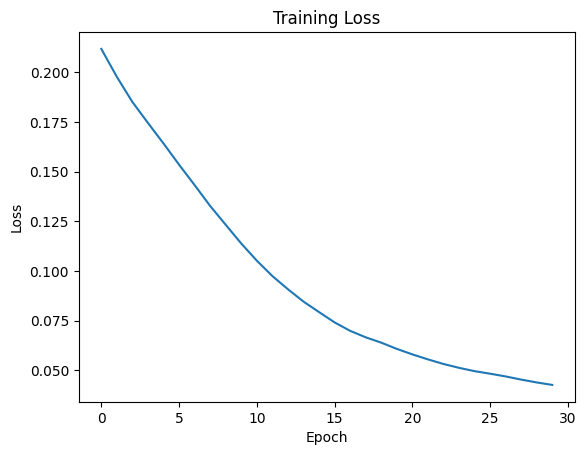

In [ ]:
losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    for fmri, img, _ in train_loader:
        fmri, img = fmri.to(device), img.to(device)
        optimizer.zero_grad()
        out = model(fmri)
        loss_pix = criterion_pixel(out, img)
        loss_feat = criterion_feat(alex(out), alex(img))
        loss = loss_pix + 0.1 * loss_feat
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
print("\nReconstructing test images and saving to PNG...")
test_dataset = FMRIImageDataset(TEST_H5, TEST_IMG_DIR, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for fmri, _, label in test_loader:
        fmri = fmri.to(device)
        recon = model(fmri).cpu().squeeze(0)
        recon_img = recon.permute(1, 2, 0).numpy() * 255
        recon_img = recon_img.astype(np.uint8)
        im = Image.fromarray(recon_img)
        im.save(os.path.join(SAVE_DIR, f'{label[0]}.png'))

print("✅ All reconstructions saved to:", SAVE_DIR)


Reconstructing test images and saving to PNG...
✅ All reconstructions saved to: ./Reconstructions


In [ ]:
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr



Evaluating reconstructed images...


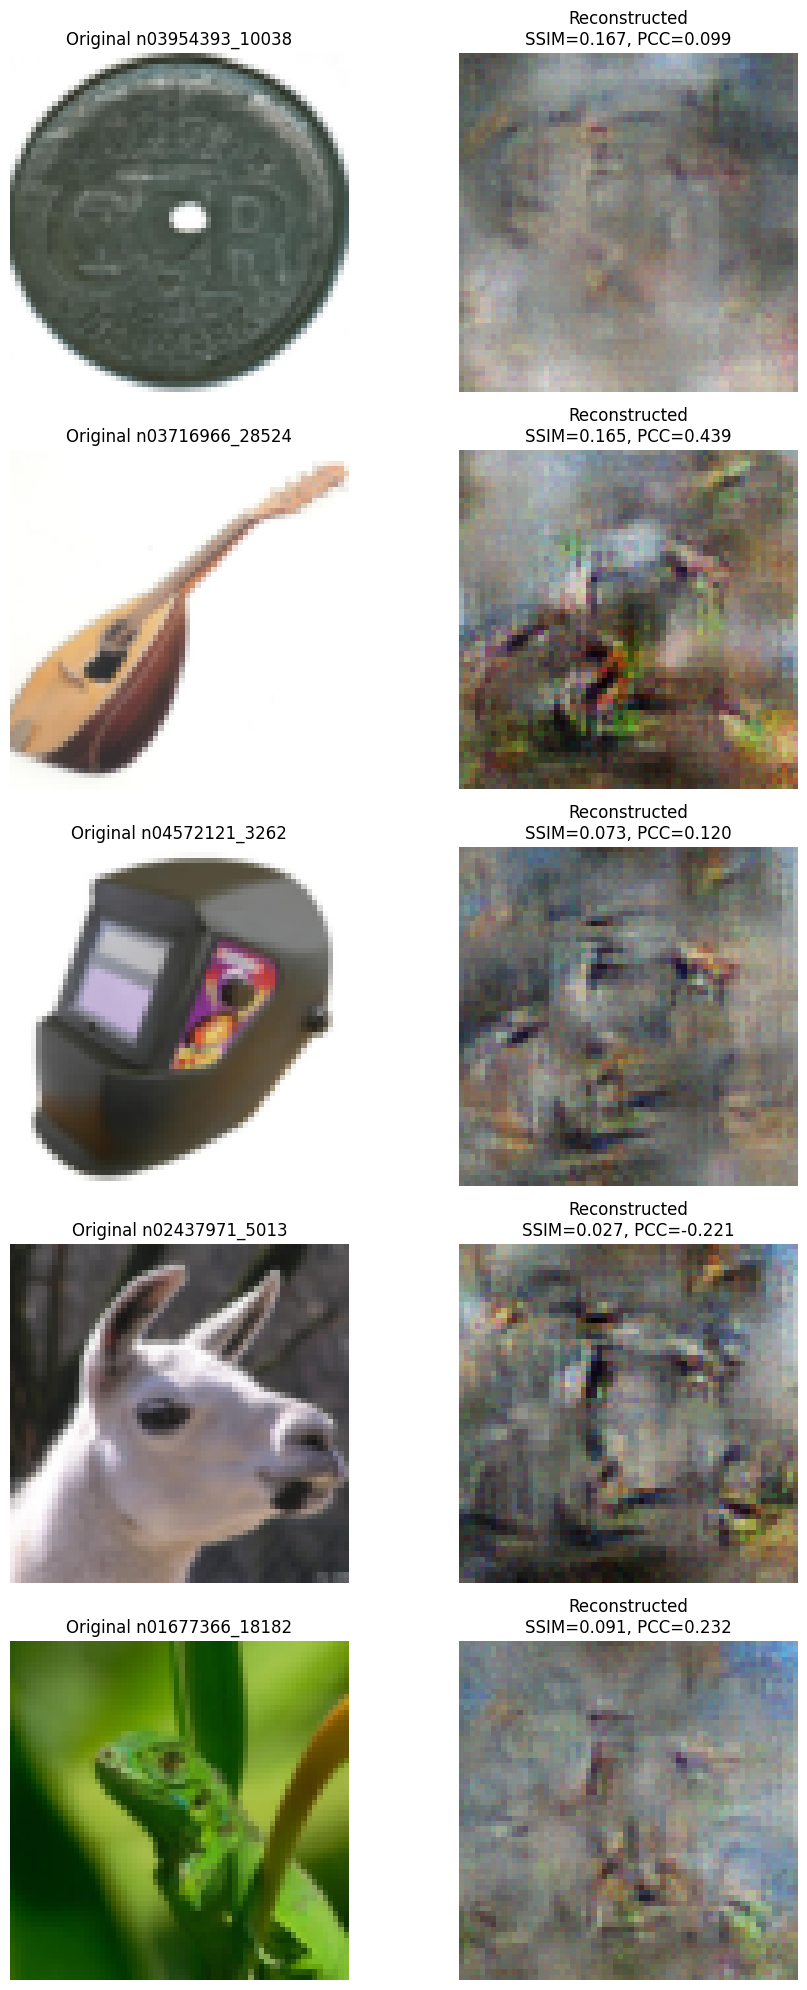


Average SSIM: 0.1043, Average Pearson Correlation: 0.1339


In [ ]:
print("\nEvaluating reconstructed images...")
test_dataset = FMRIImageDataset(TEST_H5, TEST_IMG_DIR, transform)

ssim_scores = []
pearson_scores = []

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
model.eval()
with torch.no_grad():
    for i in range(5):  # visualize 5 examples
        fmri, gt_img, label = test_dataset[i]
        fmri = fmri.unsqueeze(0).to(device)
        recon = model(fmri).cpu().squeeze(0)

        recon_np = recon.permute(1, 2, 0).numpy()
        gt_np = gt_img.permute(1, 2, 0).numpy()

        # Ensure image is in range 0–1 and shape is at least 7x7 for SSIM
        recon_np = np.clip(recon_np, 0, 1)
        gt_np = np.clip(gt_np, 0, 1)

        ssim_val = ssim(gt_np, recon_np, win_size=7, data_range=1.0, channel_axis=2)
        pearson_val = pearsonr(gt_np.flatten(), recon_np.flatten())[0]

        ssim_scores.append(ssim_val)
        pearson_scores.append(pearson_val)

        axes[i][0].imshow(gt_np)
        axes[i][0].set_title(f"Original {label}")
        axes[i][0].axis('off')

        axes[i][1].imshow(recon_np)
        axes[i][1].set_title(f"Reconstructed\nSSIM={ssim_val:.3f}, PCC={pearson_val:.3f}")
        axes[i][1].axis('off')

avg_ssim = np.mean(ssim_scores)
avg_pcc = np.mean(pearson_scores)

plt.tight_layout()
plt.show()
print(f"\nAverage SSIM: {avg_ssim:.4f}, Average Pearson Correlation: {avg_pcc:.4f}")

In [ ]:
!git clone https://github.com/OpenNeuroDatasets/ds001506.git

Cloning into 'ds001506'...
remote: Enumerating objects: 14576, done.
remote: Counting objects: 100% (557/557), done.
remote: Compressing objects: 100% (344/344), done.
remote: Total 14576 (delta 110), reused 370 (delta 89), pack-reused 14019 (from 1)
Receiving objects: 100% (14576/14576), 2.04 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (3550/3550), done.
